# Logistic regression SI 


In [3]:
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


T=1.6


In [4]:
df = pd.read_csv('../data/fitness_data.csv')
df['mutations_x'] = df['mutations_x'].str.replace('[', '')
df['mutations_x'] = df['mutations_x'].str.replace(']', '')
df['mutations_x'] = df['mutations_x'].str.replace(' ', '')

df['mutations_x'] = df['mutations_x'].str.replace("'", '')
df['mutations_x'] = df['mutations_x'].str.replace("''", '')

# create list of mutations
df['mutations_x'] = df['mutations_x'].apply(lambda x: x.split(','))
# to list
df['mutations_x'] = df['mutations_x'].apply(lambda x: list(x))
# rename delta as deltaG_fold
df = df.rename(columns={'delta': 'deltaG_fold'})
# drop if log10Kd_ACE2 is 5
df = df[df['log10Kd_ACE2'] != 5]
df['real_f'] = df['s'].values + 1
features = ['log10Kd_ACE2', 'log10Kd_CB6',
            'log10Kd_CoV555', 'log10Kd_REGN10987', 'log10Kd_S309']

for feature in features:
    new_column_name = 'ln_' + feature[5:]
    # Calculate natural logarithm by multiplying log to base 10 value by ln(10)
    df[new_column_name] = df[feature] * np.log(10)

ln_features = ['ln_Kd_ACE2', 'ln_Kd_CB6',
               'ln_Kd_CoV555', 'ln_Kd_REGN10987', 'ln_Kd_S309']
print(df[ln_features].describe())



         ln_Kd_ACE2     ln_Kd_CB6  ln_Kd_CoV555  ln_Kd_REGN10987    ln_Kd_S309
count  32565.000000  32565.000000  32565.000000     32565.000000  32565.000000
mean      19.966415     16.334477     16.226086        19.105824     20.409144
std        1.609653      4.863255      4.458415         4.792152      0.658289
min       15.831589     11.512925     11.512925        11.512925     17.696580
25%       18.714290     11.512925     11.512925        11.512925     19.950611
50%       20.210212     18.461139     16.435928        21.563236     20.437766
75%       21.350267     21.136555     20.702641        22.626989     20.901937
max       23.118244     24.317747     24.542330        24.880015     23.056486


In [5]:
#only keep existing variants
df = df[df['count'] > 0]
df_all = df

In [6]:
mu = 'S:T478K'
df_with = df_all[df_all['mutations_x'].apply(lambda x: mu in x)]
df_without = df_all[~df_all['mutations_x'].apply(lambda x: mu in x)]


In [7]:
df_with[ln_features].describe()


,ln_Kd_ACE2,ln_Kd_CB6,ln_Kd_CoV555,ln_Kd_REGN10987,ln_Kd_S309
count,756.000000,756.000000,756.000000,756.000000,756.000000
mean,20.325695,15.942605,15.241077,18.723680,20.532694
std,1.524170,4.634882,4.441272,5.115800,0.817877
min,16.092078,11.512925,11.512925,11.512925,18.185177
25%,19.124529,11.512925,11.512925,11.512925,19.819426
50%,20.710187,11.512925,11.512925,21.641860,20.526293
75%,21.624491,19.955465,18.000724,23.001129,21.163634
max,22.763346,24.198907,23.634215,24.346699,22.857840


In [8]:
def logistic_model(x, a, T, C, K_1, K_2, K_3, K_4):
    return a * (1+C * np.exp(np.log(10)*x[0]/T)) / (C * np.exp(np.log(10)*x[0]/T) + K_1 * np.exp(np.log(10)*x[1]/T) + K_2 * np.exp(np.log(10)*x[2]/T) + K_3 * np.exp(np.log(10)*x[3]/T) + K_4 * np.exp(np.log(10)*x[4]/T) + 1)
df = df_without
# Define the x and y data
x_data = df[features].values.T  # Transpose the data for curve_fit
y_data = df['real_f'].values
parameter_bounds = ([0, 0, 0, 0, 0, 0],
                    [np.inf, np.inf, np.inf, np.inf, np.inf , np.inf])

# Fit on whole dataset

In [9]:

df = df_without
# Define the x and y data
x_data = df[features].values.T  # Transpose the data for curve_fit

y_data = df['real_f'].values
parameter_bounds = ([0, 0, 0, 0, 0, 0],
                    [np.inf, np.inf, np.inf, np.inf, np.inf , np.inf])

# Perform curve fitting with the 'lm' method on the training data

x_train, x_test, y_train, y_test = train_test_split(
    x_data.T, y_data, test_size=0.001, random_state=0)

# Perform curve fitting with the 'lm' method on the training data
initial_guess = [1,  1e-8, 1e-8, 1e-8, 1e-8, 1e-8]
parameters, _ = curve_fit(lambda x, a, C, K_1, K_2, K_3, K_4: logistic_model(x, a, T, C, K_1, K_2, K_3, K_4)
                          , x_train.T, y_train, p0=initial_guess,
                          bounds=parameter_bounds, method='trf', maxfev=1000000)

# Extract the fitted parameters
a_fit_without,  C_fit_without, K_1_fit_without, K_2_fit_without, K_3_fit_without, K_4_fit_without = parameters

# Print the fitted parameters
print("Fitted Parameters without T478K:")
print("a:", a_fit_without)
print("C:", C_fit_without)
print("K_1:", K_1_fit_without)
print("K_2:", K_2_fit_without)
print("K_3:", K_3_fit_without)
print("K_4:", K_4_fit_without)
df = df_with
x_data = df[features].values.T  # Transpose the data for curve_fit
y_data = df['real_f'].values


parameter_bounds = ([0, 0, 0, 0, 0, 0],
                    [np.inf, np.inf, np.inf, np.inf, np.inf , np.inf])

# Perform curve fitting with the 'lm' method on the training data

# Put nearly all data in training set
x_train, x_test, y_train, y_test = train_test_split(
    x_data.T, y_data, test_size=0.001, random_state=0)

# Perform curve fitting with the 'lm' method on the training data
initial_guess = [1,  1e-8, 1e-8, 1e-8, 1e-8, 1e-8]
parameters, _ = curve_fit(lambda x, a, C, K_1, K_2, K_3, K_4: logistic_model(x, a, T, C, K_1, K_2, K_3, K_4)
                          , x_train.T, y_train, p0=initial_guess,
                          bounds=parameter_bounds, method='trf', maxfev=1000000)

# Extract the fitted parameters
a_fit_without,  C_fit_without, K_1_fit_without, K_2_fit_without, K_3_fit_without, K_4_fit_without = parameters

# Print the fitted parameters
print("Fitted Parameters with T478K:")
print("a:", a_fit_without)
print("C:", C_fit_without)
print("K_1:", K_1_fit_without)
print("K_2:", K_2_fit_without)
print("K_3:", K_3_fit_without)
print("K_4:", K_4_fit_without)





Fitted Parameters without T478K:
a: 1.5736856665722125
C: 5.57983604203103e-07
K_1: 5.627340866535784e-08
K_2: 4.498441775283275e-08
K_3: 7.243937789928991e-08
K_4: 4.743040179246782e-07
Fitted Parameters with T478K:
a: 2.271807944166785
C: 6.603640307381371e-07
K_1: 9.533749607731461e-08
K_2: 6.763608769213796e-08
K_3: 6.944071066351239e-08
K_4: 4.358162660130266e-07


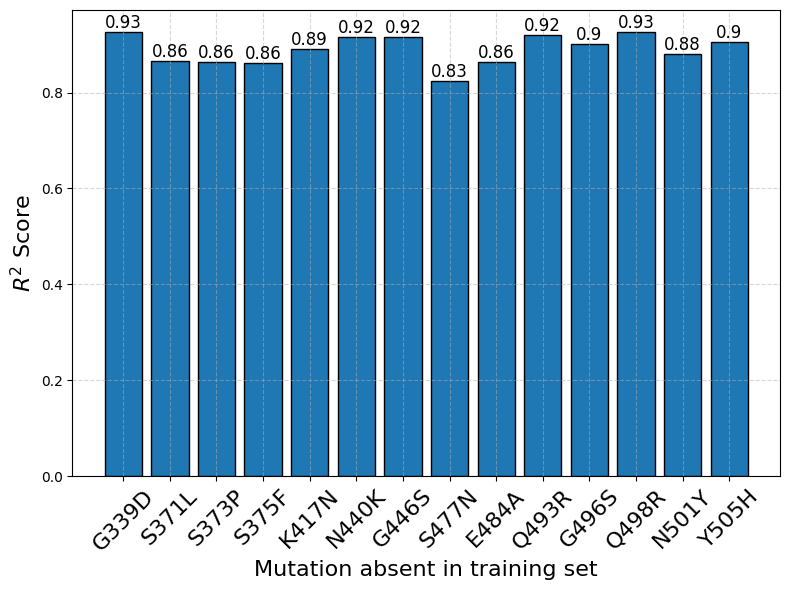

In [10]:
r2list=[]
mutations_truncated=['S:G339D',
 'S:S371L',
 'S:S373P',
 'S:S375F',
 'S:K417N',
 'S:N440K',
 'S:G446S',
 'S:S477N',
 'S:E484A',
 'S:Q493R',
 'S:G496S',
 'S:Q498R',
 'S:N501Y',
 'S:Y505H']

                     
for mu in mutations_truncated:

    df_with_with = df_with[df_with['mutations_x'].apply(lambda x: mu in x)]
    df_with_without = df_with[~df_with['mutations_x'].apply(lambda x: mu in x)]
    df_without_with = df_without[df_without['mutations_x'].apply(lambda x: mu in x)]
    df_without_without = df_without[~df_without['mutations_x'].apply(lambda x: mu in x)]
    features=features
    X_with_with,y_with_with= df_with_with[features].values,df_with_with['real_f'].values
    X_with_without,y_with_without= df_with_without[features].values,df_with_without['real_f'].values
    X_without_with,y_without_with= df_without_with[features].values,df_without_with['real_f'].values
    X_without_without,y_without_without= df_without_without[features].values,df_without_without['real_f'].values

    param_with,_=curve_fit(lambda x, a, C, K_1, K_2, K_3, K_4: logistic_model(x, a, T, C, K_1, K_2, K_3, K_4),
                           X_with_without.T,y_with_without,p0=initial_guess,bounds=parameter_bounds,method='trf',maxfev=1000000)
    param_without,_=curve_fit(lambda x, a, C, K_1, K_2, K_3, K_4: logistic_model(x, a, T, C, K_1, K_2, K_3, K_4),
                              X_without_without.T,y_without_without,p0=initial_guess,bounds=parameter_bounds,method='trf',maxfev=1000000)

    param_with=np.insert(param_with,1,T)
    param_without=np.insert(param_without,1,T)
    y_with_with_pred=logistic_model(X_with_with.T,*param_with)
    y_without_with_pred=logistic_model(X_without_with.T,*param_without)

    y_with_pred=np.concatenate((y_without_with_pred,y_with_with_pred))
    y_with=np.concatenate((y_without_with,y_with_with))
    r2list.append(r2_score(y_with, y_with_pred))

fig, ax = plt.subplots(figsize=(8, 6))  

# Plot the bar chart
mutations_truncated_txt = [mut.replace('S:', '') for mut in mutations_truncated]
bars = ax.bar(mutations_truncated_txt, r2list)

ax.set_ylabel(r'$R^2$ Score', fontsize=16)  
ax.set_xlabel('Mutation absent in training set', fontsize=16)
ax.tick_params(axis='x', labelrotation=45, labelsize=16) 
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, round(height, 2),
            ha='center', va='bottom', fontsize=12)
    bar.set_edgecolor('black')
    bar.set_linewidth(1)

fig.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('pred_test_mut.png', dpi=300)  
plt.show()
   

In [11]:
AV_LN_FEAT=[]
for feature in features:
    AV_LN_FEAT.append(np.mean(df[feature].values))
print(AV_LN_FEAT)


[8.827336972661108, 6.923785578849575, 6.619115562027174, 8.131590917229175, 8.917235613684376]


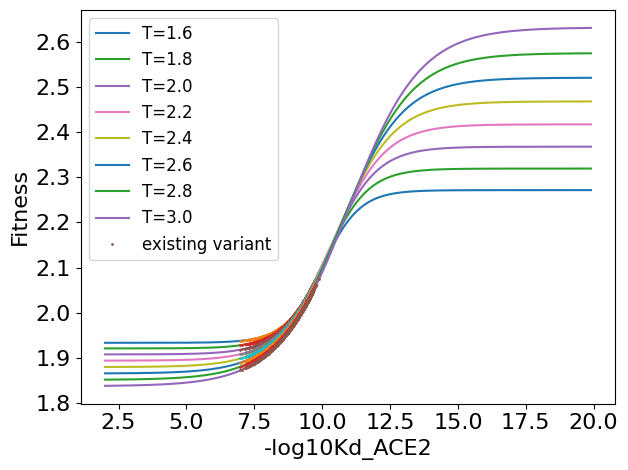

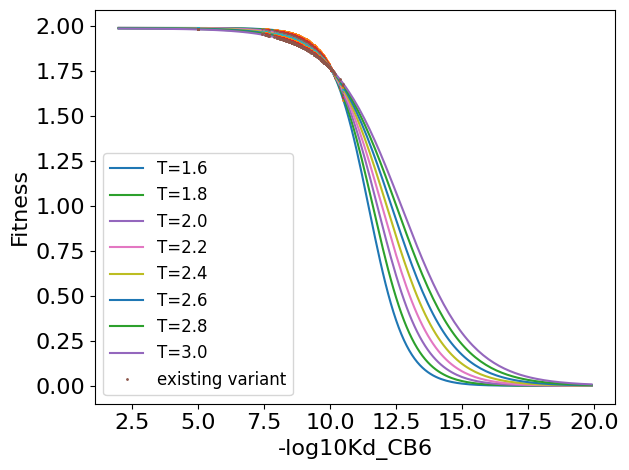

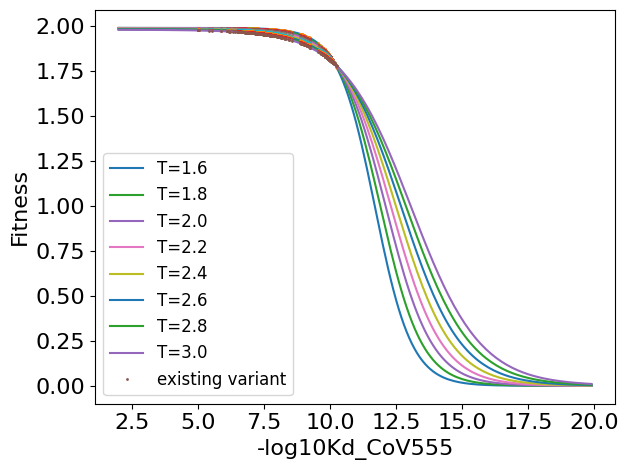

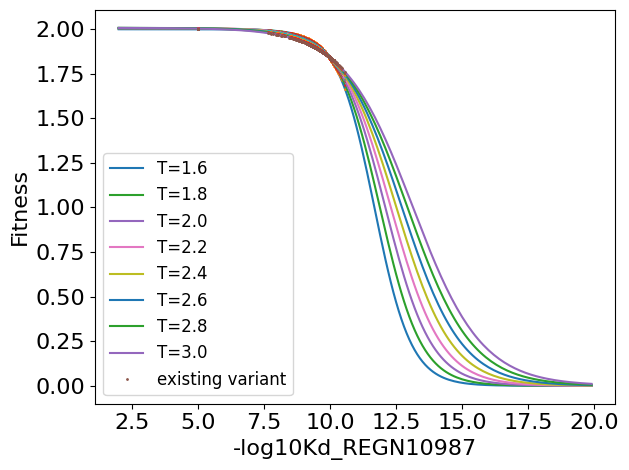

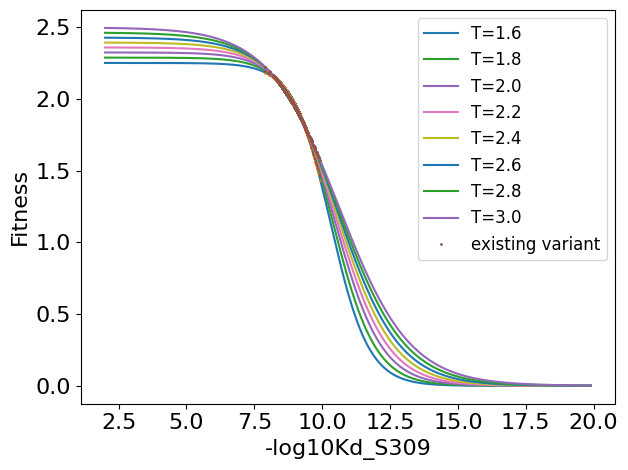

In [12]:
param_matrix=[]
x_data = df_with[features].values.T  # Transpose the data for curve_fit
y_data = df_with['real_f'].values
#fit logistic model for different constraints on T and add the parameters to param_matrix
for T in np.arange(1.5,3,0.2):

    initial_guess = [1, T, 1e-8, 1e-8, 1e-8, 1e-8, 1e-8]
    parameter_bounds = ([0, T-0.1, 0, 0, 0, 0, 0],
                        [np.inf, T+0.1, np.inf, np.inf, np.inf, np.inf, np.inf])
    param,_=curve_fit(logistic_model,x_data,y_data,p0=initial_guess,bounds=parameter_bounds,method='trf',maxfev=1000000)
    param_matrix.append(param)

#linear regression
reg=LinearRegression().fit(x_data.T,y_data)

for feature in features:
    
    for t in range (len(param_matrix)):
        param=param_matrix[t]
        y_array=[]
        y_reg_array=[]

        feat_data=np.arange(2,20,0.1)
        for i in range(len(feat_data)):
            x_data=np.array(AV_LN_FEAT)
            x_data[features.index(feature)]=feat_data[i]
            y=logistic_model(x_data,param[0],param[1],param[2],param[3],param[4],param[5],param[6])
            y_array.append(y)
            y_reg=reg.predict(x_data.reshape(1,-1))
            y_reg_array.append(y_reg)
        plt.plot(feat_data,y_array,label='T='+str(round(param[1],2)))
        # for each value in df[feature], plot the predicted fitness
        x_data_exis_array=[]
        y_exis_array=[]
        for i in range (len(df[feature])):
            x_data_exis=np.array(AV_LN_FEAT)
            x_data_exis[features.index(feature)]=df[feature].values[i]
            y_exis=logistic_model(x_data_exis,param[0],param[1],param[2],param[3],param[4],param[5],param[6])
            x_data_exis_array.append(x_data_exis)
            y_exis_array.append(y_exis)
        if t == len(param_matrix)-1:
            plt.plot(df[feature],y_exis_array,'o',label='existing variant', alpha=1, markersize=1)
        else:
            plt.plot(df[feature],y_exis_array,'o', alpha=1, markersize=1)
        
    plt.figsize=(10,8)
    plt.xlabel('-'+feature, fontsize=16)
    plt.ylabel('Fitness', fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=12)
    fig.subplots_adjust(bottom=0.2)

    plt.tight_layout()

    plt.savefig('pred_temp_'+feature+'.png', dpi=300)  
    plt.show()


feature log10Kd_ACE2


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


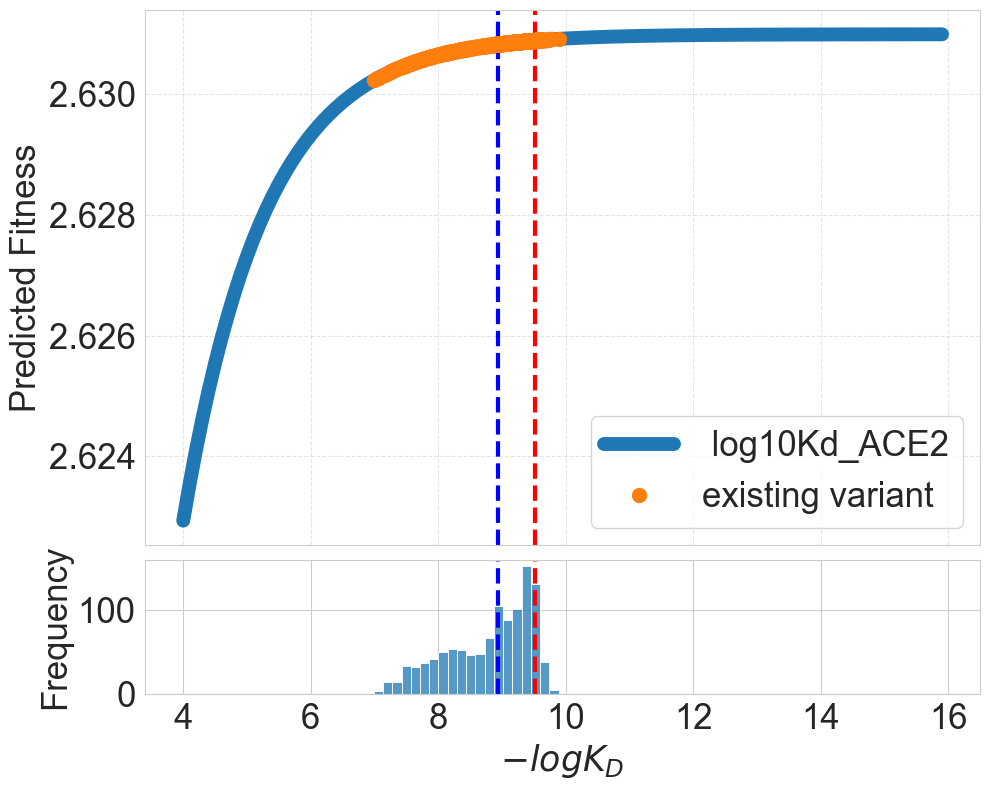

feature log10Kd_CB6


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


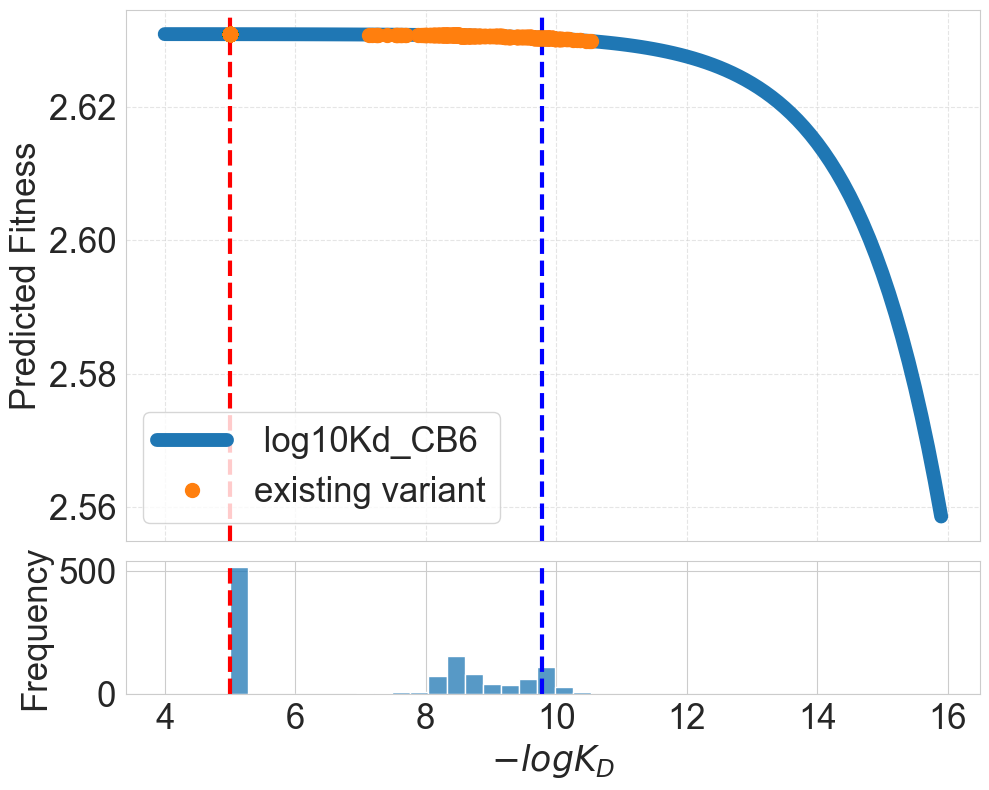

feature log10Kd_CoV555


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


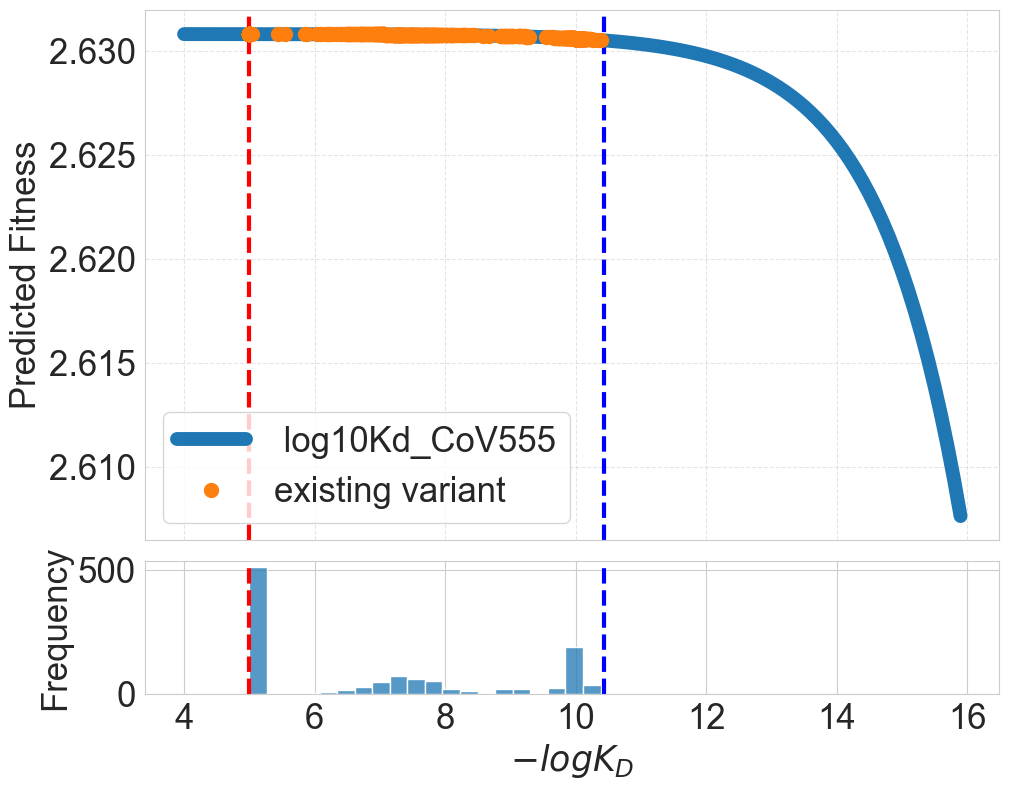

feature log10Kd_REGN10987


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


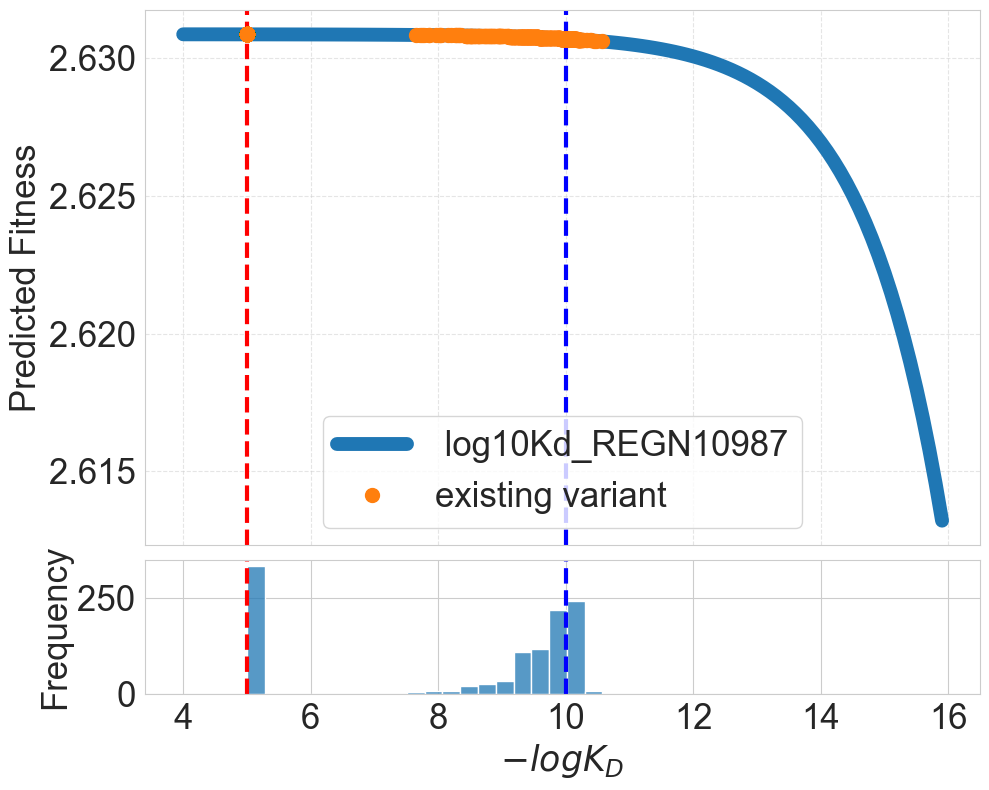

feature log10Kd_S309


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


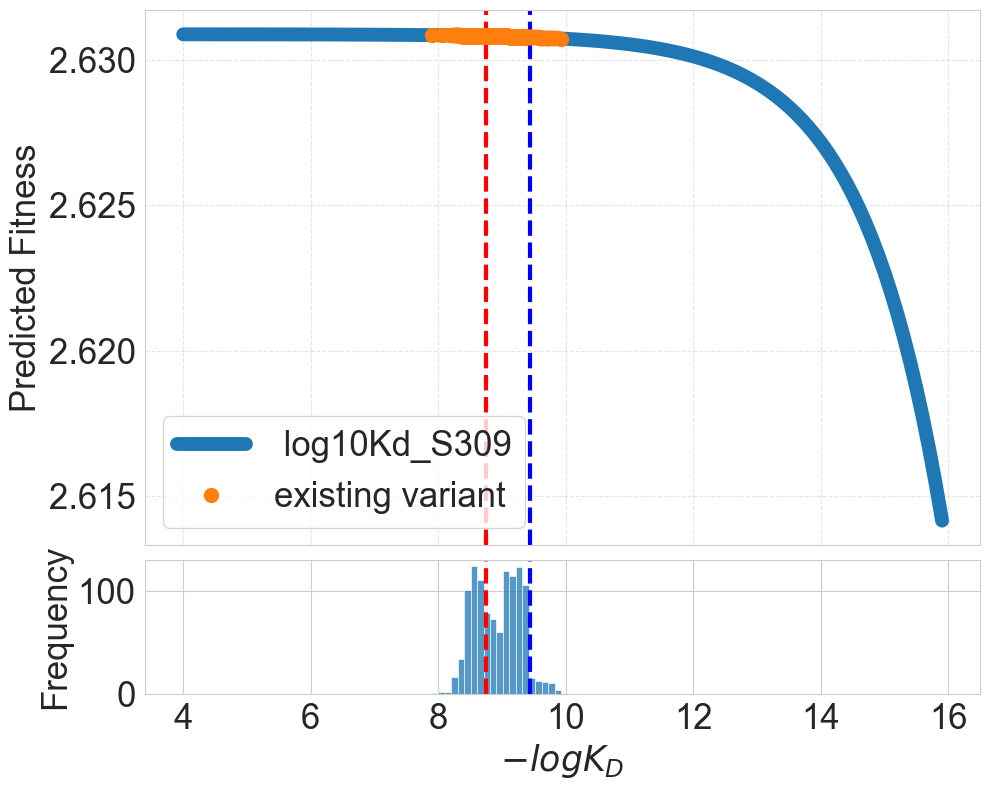

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec

sns.set_style("whitegrid")
Wuhan_feature = [8.937612, 9.784244, 10.438193, 10.007482, 9.433568]
Omicron_feature = [9.524069, 5.000000, 5.000000, 5.000000, 8.750185]

for idx, feature in enumerate(features):
    fig = plt.figure(figsize=(10, 8))
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
    ax = plt.subplot(gs[0])
    ax_hist = plt.subplot(gs[1], sharex=ax)
    linewidth=3
    ax.axvline(Wuhan_feature[idx], color='blue', linestyle='--',linewidth=linewidth)
    ax.axvline(Omicron_feature[idx], color='red', linestyle='--',linewidth=linewidth)
    print('feature', feature)
    
    y_array = []
    y_exis_array = []
    feat_data = np.arange(4, 16, 0.1)
    
    for i in range(len(feat_data)):
        x_data = np.array(AV_LN_FEAT)
        x_data[features.index(feature)] = feat_data[i]
        y = logistic_model(x_data, param[0], T, param[1], param[2], param[3], param[4], param[5])
        y_array.append(y)
    ax.plot(feat_data, y_array, label=f' {feature}', lw=10)

    for i in range(len(df_all[feature])):
        x_data_exis = np.array(AV_LN_FEAT)
        x_data_exis[features.index(feature)] = df_all[feature].values[i]
        y_exis = logistic_model(x_data_exis, param[0], T, param[1], param[2], param[3], param[4], param[5])
        y_exis_array.append(y_exis)

    ax.plot(df_all[feature], y_exis_array, 'o', label='existing variant', alpha=1, markersize=10)
    ax.tick_params(labelbottom=False)
    ax.set_xlabel('') 
    ax.set_ylabel('Predicted Fitness', fontsize=25)
    ax.tick_params(labelsize=25)
    ax.legend(loc='best', fontsize=25)
    ax.grid(True, linestyle='--', alpha=0.5)

    # Plot the histogram of KD values
    sns.histplot(df_all[feature], bins=20, kde=False, ax=ax_hist)
    ax_hist.set_xlabel('$-log K_D$', fontsize=25)
    ax_hist.set_ylabel('Frequency', fontsize=25)
    ax_hist.tick_params(labelsize=25)
    ax_hist.axvline(Wuhan_feature[idx], color='blue', linestyle='--', linewidth=linewidth)
    ax_hist.axvline(Omicron_feature[idx], color='red', linestyle='--',linewidth=linewidth)
    # Ensure that the main plot doesn't overlap with the histogram
    plt.subplots_adjust(hspace=0.4)
    plt.tight_layout()
    
    plt.savefig(f'pred_fitness_lnKD_{feature}.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'pred_fitness_lnKD_{feature}.eps', dpi=1200, bbox_inches='tight')
    plt.show()
